In [1]:
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./aidata",
						train = True,
						download = True,
						transform = tensor_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
									batch_size = 32,
									shuffle = True)

8.3%

100.0%


Extracting ./aidata\MNIST\raw\train-images-idx3-ubyte.gz to ./aidata\MNIST\raw


100.0%
2.0%


Extracting ./aidata\MNIST\raw\train-labels-idx1-ubyte.gz to ./aidata\MNIST\raw



100.0%
100.0%


Extracting ./aidata\MNIST\raw\t10k-images-idx3-ubyte.gz to ./aidata\MNIST\raw

Extracting ./aidata\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./aidata\MNIST\raw



In [3]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 9)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(9, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [4]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)

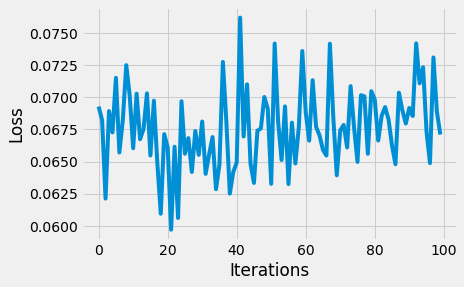

In [8]:
epochs = 3
outputs = []
losses = []
for epoch in range(epochs):
	for (image, _) in loader:
	
		# Reshaping the image to (-1, 784)
		image = image.reshape(-1, 28*28)
		
		# Output of Autoencoder
		reconstructed = model(image)
		
		# Calculating the loss function
		loss = loss_function(reconstructed, image)
		
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss.detach())
		outputs.append((epochs, image, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])

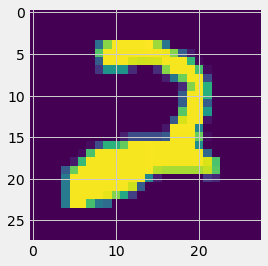

In [12]:
for i, item in enumerate(image):
    # Reshape the array for plotting
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0].detach())

for i, item in enumerate(reconstructed):
    item = item.reshape(-1, 28, 28)
    # plt.imshow(item[0].detach())
